https://github.com/openai/gym/wiki/CartPole-v0

In [1]:
import gym
import numpy as np

In [2]:
import time

env = gym.make('CartPole-v0')
for i_episode in range(1):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        print(action)
        print(time.sleep(0.1))
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[2018-01-15 20:47:57,137] Making new env: CartPole-v0


[ 0.03480703 -0.04522581  0.04244589  0.0005387 ]
0
None
[ 0.03390251 -0.24092999  0.04245666  0.3063059 ]
1
None
[ 0.02908391 -0.04643795  0.04858278  0.02730924]
1
None
[ 0.02815516  0.14795484  0.04912896 -0.24965817]
0
None
[ 0.03111425 -0.04783302  0.0441358   0.05810738]
1
None
[ 0.03015759  0.14662923  0.04529795 -0.22033022]
1
None
[ 0.03309018  0.3410754   0.04089134 -0.49838725]
1
None
[ 0.03991168  0.53559768  0.0309236  -0.77790805]
1
None
[ 0.05062364  0.73028106  0.01536544 -1.06070342]
1
None
[ 0.06522926  0.92519618 -0.00584863 -1.34852432]
1
None
[ 0.08373318  1.12039114 -0.03281912 -1.64303125]
1
None
[ 0.10614101  1.31588161 -0.06567974 -1.94575613]
0
None
[ 0.13245864  1.12151773 -0.10459486 -1.67413489]
0
None
[ 0.15488899  0.92775397 -0.13807756 -1.4157725 ]
1
None
[ 0.17344407  1.12428949 -0.16639301 -1.7482359 ]
0
None
[ 0.19592986  0.93140336 -0.20135773 -1.51159687]
0
None
Episode finished after 16 timesteps


In [3]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Discrete(2)
Box(4,)
[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


In [6]:
x = np.array([-2.4, 0, -4.0, 4, 2])
bins = np.linspace(-4.8, 4.8, 12)
out = np.digitize(x, bins)
print("bins:", bins)
print("x:", x, "out:", out)

a = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 8) for i in range(4)]

print(len(a))
print(a)

bins: [-4.8        -3.92727273 -3.05454545 -2.18181818 -1.30909091 -0.43636364
  0.43636364  1.30909091  2.18181818  3.05454545  3.92727273  4.8       ]
x: [-2.4  0.  -4.   4.   2. ] out: [ 3  6  1 11  8]
4
[array([-4.8       , -3.42857143, -2.05714286, -0.68571429,  0.68571429,
        2.05714286,  3.42857143,  4.8       ]), array([ -3.40282347e+38,  -2.43058819e+38,  -1.45835291e+38,
        -4.86117638e+37,   4.86117638e+37,   1.45835291e+38,
         2.43058819e+38,   3.40282347e+38]), array([-0.41887902, -0.2991993 , -0.17951958, -0.05983986,  0.05983986,
        0.17951958,  0.2991993 ,  0.41887902]), array([ -3.40282347e+38,  -2.43058819e+38,  -1.45835291e+38,
        -4.86117638e+37,   4.86117638e+37,   1.45835291e+38,
         2.43058819e+38,   3.40282347e+38])]


In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import unittest
import math


# env = gym.make('CartPole-v0')
# env.reset()


# Qlearner for CartPole
class QLearner():
    def __init__(self, env):
        self.env = env
        self.epsilon_start = 0.1 # 1-epsilon probability of selecting best action
        self.epsilon_end = 0.99 # final epsilon value
        self.epsilon_decay = 5000 # steps before epsilon reaches epsilon_end
        self.epsilon_step = 0 #step tracker
        self.alpha = 0.01
        self.gamma = 0.99
        
        # get initial state, divide continuous states into discrete bins
#         self.bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 7) for i in range(4)]
        self.bins = []
        self.bins.append(np.linspace(-2.4, 2.4, 1))
        self.bins.append(np.linspace(-0.5, 0.5, 1))
        self.bins.append(np.linspace(-41.8, 41.8, 5))
        self.bins.append(np.linspace(-math.radians(50), math.radians(50), 3))
        self.reset()
        
        #initialize Q
        self.Q = np.zeros((2, 2, 6, 4, 2))
#         print(self.bins)

        self.episode_durations = []
        
    
    def getQ(self, s, action):
        return self.Q[s[0], s[1], s[2], s[3], action]
    
    
    def setQ(self, s, s_plus1, action, r):
#         print("Setting Q: ")
#         print("s: ", s, "s_plus1: ", s_plus1, " action: ", action, " r: ", r)
#         print("s:", s[0], s[1], s[2], s[3], "action: ", action)
        q = self.getQ(s, action)
        max_q_splus1 = np.max(self.Q[s_plus1[0], s_plus1[1], s_plus1[2], s_plus1[3]])
#         print("q: ", q, " max_q_splus1: ", max_q_splus1)
        new_q = q + self.alpha * (r + self.gamma * max_q_splus1 - q)

#         print("new q: ", new_q, " position: ", s[0], s[1], s[2], s[3], action)
        self.Q[s[0], s[1], s[2], s[3], action] = new_q
    
    def get_best_action(self, s):
        return np.argmax(self.Q[s[0], s[1], s[2], s[3]])
    
    def get_epsilon(self):
        return min(self.epsilon_end, self.epsilon_start + 
                      self.epsilon_step / self.epsilon_decay * (self.epsilon_end - self.epsilon_start))
    
    def get_training_action(self):
        epsilon = self.get_epsilon()

        if np.random.rand() >= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.get_best_action(self.s_bins)
        
        self.epsilon_step += 1
        return action
    
    def reset(self):
        self.s = env.reset()
        self.s_bins = [np.digitize(self.s[i], self.bins[i]) for i in range(4)]
        self.s_bins[0] = 0
        self.s_bins[1] = 0
    
    def step(self, action, training=False):
        s_plus1, r, done, _ = self.env.step(action)
#         print("s0:", self.s)
#         print("s1:", s_plus1)
#         print("velocity:", s_plus1[3])
        s_bins = [np.digitize(s_plus1[i], self.bins[i]) for i in range(4)]
        s_bins[0] = 0
        s_bins[1] = 0
#         if training:
        self.setQ(self.s_bins, s_bins, action, r)
        
        self.s_bins = s_bins
        
        return r, done
    
    def train(self, nb_episodes=2):
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_training_action()
                r, done = self.step(action, training=True)
                episode_reward += r
                
                if done:
                    break;
            self.episode_durations.append(episode_reward + 1)
#             self.plot_durations()            
#             print("Episode reward: ", episode_reward)

    def run(self):
        self.reset()
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_best_action(self.s_bins)
            r, done = self.step(action)
            episode_reward += r
#             time.sleep(0.1)
            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
            
#     def plot_durations(self):
#         plt.figure(2)
#         plt.clf()
# #         durations_t = torch.FloatTensor(episode_durations)
#         plt.title('Training...')
#         plt.xlabel('Episode')
#         plt.ylabel('Duration')
#         plt.plot(self.episode_durations)
#         # Take 100 episode averages and plot them too
# #         if len(durations_t) >= 100:
# #             means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
# #             means = torch.cat((torch.zeros(99), means))
# #             plt.plot(means.numpy())

#         plt.pause(0.001)  # pause a bit so that plots are updated
#         if is_ipython:
#             display.clear_output(wait=True)
#             display.display(plt.gcf())


class TestQlearner(unittest.TestCase):
    def setUp(self):
        env = gym.make('CartPole-v0')
        self.qlearner = QLearner(env)

    def test_setQ(self):
        self.qlearner.setQ([4, 4, 4, 4], [4, 4, 4, 5], 1, 1)
        self.assertEqual(self.qlearner.getQ([4, 4, 4, 4], 1), 0.01)
        
        print(' ')
        self.qlearner.setQ([4, 4, 4, 5], [4, 4, 4, 4], 0, 1)
        newQ = self.qlearner.getQ([4, 4, 4, 5], 0)
        self.assertEqual(newQ, 0.010099)
        
        
    def runTest(self):
        self.test_setQ()
        



# tester = TestQlearner()
# tester.debug()


[2018-01-15 21:56:19,085] Making new env: CartPole-v0


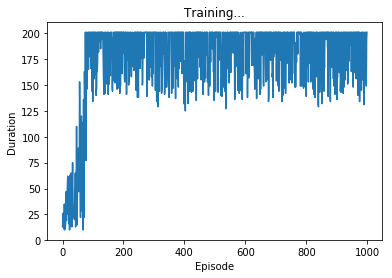

In [13]:
env = gym.make('CartPole-v0')
qlearner = QLearner(env)

qlearner.train(nb_episodes=500)
plt.figure(2)
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(qlearner.episode_durations)



In [16]:
# env.close()
qlearner.run()
# env.close()

Total Reward:  200.0


In [ ]:
qlearner.Q[0, 0, 3, 2]

In [ ]:
# qlearner.Q[3:6, 3:6, 3:6, 3:6]
print(qlearner.get_epsilon(), qlearner.epsilon_step)

In [ ]:
start = 0.1
end = 0.95
decay = 10
step = 11

epsilon = min(end, start + step / decay * (end - start))
print(epsilon)

In [ ]:
np.linspace(-100, 100, 2)

# The above doesn't seem right, have to reduce dimension significantly
## which means it requiers n-step bootstrapping rather than 1 step or we'll have to use a rollout 

In [35]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import unittest
import math


# env = gym.make('CartPole-v0')
# env.reset()


# Qlearner for CartPole
class QLearner():
    def __init__(self, env):
        self.env = env
        self.epsilon_start = 1. # 1-epsilon probability of selecting best action. The epsilon is the greedy
        self.epsilon_end = 0.01 # final epsilon value
        self.epsilon_decay = 500 # steps before epsilon reaches epsilon_end
        self.epsilon_step = 0 #step tracker
        self.alpha = 0.1
        self.gamma = 0.99
        
        # get initial state, divide continuous states into discrete bins
#         self.bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 7) for i in range(4)]
        self.bins = []
        self.bins.append(np.linspace(-2.4, 2.4, 5))
        self.bins.append(np.linspace(-0.5, 0.5, 5))
        self.bins.append(np.linspace(-41.8, 41.8, 5))
        self.bins.append(np.linspace(-math.radians(50), math.radians(50), 5))
        self.reset()
        
        #initialize Q
#         self.Q = np.zeros((20, 20, 20, 20, 2))
        self.Q = {}
#         print(self.bins)

        self.episode_durations = []
        
    
    def getQ(self, s, action=None):
#         return self.Q[s[0], s[1], s[2], s[3], action]
#         print('getQ:', s, action)
        if not s in self.Q:
            self.Q[s] = [0, 0]

        if action is not None:
            return self.Q[s][action]
        else:
            return self.Q[s]
    
    
    def setQ(self, s, s_plus1, action, r):
#         print("Setting Q: ")
#         print("s: ", s, "s_plus1: ", s_plus1, " action: ", action, " r: ", r)
#         print("s:", s[0], s[1], s[2], s[3], "action: ", action)

        q = self.getQ(s, action)
        
        max_q_splus1 = np.max(self.getQ(s_plus1))
#         print("q: ", q, " max_q_splus1: ", max_q_splus1)
        new_q = q + self.alpha * (r + self.gamma * max_q_splus1 - q)

        self.Q[s][action] = new_q
    
    def get_best_action(self, s):
        return np.argmax(self.getQ(s))
    
    def get_epsilon(self):
        return max(self.epsilon_end, self.epsilon_start + 
                      self.epsilon_step / self.epsilon_decay * (self.epsilon_end - self.epsilon_start))
    
    def get_training_action(self):
        epsilon = self.get_epsilon()

        if np.random.rand() >= epsilon:
            action = self.get_best_action(self.s)
        else:
            action = self.env.action_space.sample()
        
        self.epsilon_step += 1
        return action
    
    def reset(self):
        s = env.reset()
        self.s = tuple([np.asscalar(np.digitize(s[i], self.bins[i])) for i in range(4)])
    
    def step(self, action, training=False, step=0):
        observation, r, done, _ = self.env.step(action)
#         print("s0:", self.s)
#         print("s1:", s_plus1)
#         print("velocity:", s_plus1[3])
        s_plus1 = tuple([np.asscalar(np.digitize(observation[i], self.bins[i])) for i in range(4)])
        
        if training and done and step < 200:
            r = -100
        
        self.setQ(self.s, s_plus1, action, r)
            
        self.s = s_plus1
        
        return r, done
    
    def train(self, nb_episodes=2):
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_training_action()
                r, done = self.step(action, training=True, step=episode_reward+1)
                                
                episode_reward += r
                
                if done:
                    break;
            self.episode_durations.append(episode_reward + 1)
#             self.plot_durations()            
#             print("Episode %d reward: %d epsilon: %.4f" % (episode, episode_reward, self.get_epsilon()))

    def run(self):
        self.reset()
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_best_action(self.s)
            r, done = self.step(action)
            episode_reward += r
#             time.sleep(0.1)
            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
        
class TestQlearner(unittest.TestCase):
    def setUp(self):
        env = gym.make('CartPole-v0')
        self.qlearner = QLearner(env)
        self.qlearner.alpha = 0.01
        self.qlearner.gamma = 0.99

    def test_setQ(self):
        self.qlearner.setQ((4, 4, 4, 4), (4, 4, 4, 5), 1, 1)
        print(self.qlearner.Q)
        self.assertEqual(self.qlearner.getQ((4, 4, 4, 4), 1), 0.01)
        
        print(' ')
        self.qlearner.setQ((4, 4, 4, 5), (4, 4, 4, 4), 0, 1)
        print(self.qlearner.Q)
        newQ = self.qlearner.getQ((4, 4, 4, 5), 0)
        self.assertEqual(newQ, 0.010099)
        
        
    def runTest(self):
        self.test_setQ()
        

tester = TestQlearner()
tester.debug()


[2018-01-15 22:37:53,074] Making new env: CartPole-v0


{(4, 4, 4, 5): [0, 0], (4, 4, 4, 4): [0, 0.01]}
 
{(4, 4, 4, 5): [0.010099, 0], (4, 4, 4, 4): [0, 0.01]}


[2018-01-15 22:37:53,082] Making new env: CartPole-v0


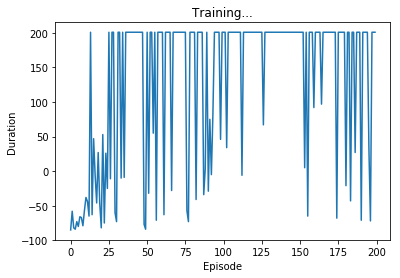

In [36]:
env = gym.make('CartPole-v0')
qlearner = QLearner(env)

qlearner.train(nb_episodes=200)
plt.figure(2)
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(qlearner.episode_durations)

In [38]:
for i in range(5):
    qlearner.run()

Total Reward:  200.0
Total Reward:  200.0
Total Reward:  200.0
Total Reward:  200.0
Total Reward:  200.0


In [ ]:
qlearner.Q[2, 2, 3, 3, None]

# Learnings
- Having a big negative reward for failing really helps with convergence when the table gets big
- bigger tabular dimensions require more training time
    - bins of [5, 5, 5, 5] seems easy to learn with and manageable.
    - bins of [7, 7, 7, 7] requires much longer training time
    - bins of [5, 5, 11, 11] is doable but takes longer and decay needs to be longer (30000)
- convergence is much better with odd number bins
- best result is when pole velocity (last state) is 3 bins
- a higher alpha (1.0 or even 0.1 vs 0.01) made a huge difference to learning

- after revisiting this I realized by accident that in a smaller state space, a faster decaying epsilon kicks ass

In [ ]:
Q = {}

Q["a"] = 1
Q[(1, 2, 0)] = "a"
Q[(1, 2, 1)] = "b"
Q[1, 2, 2] = "c"
Q[(1, 2), (0, 1)] = "z"

Q[(1, 2)] = (0, 1)
print(Q)
print(Q[(1,2)]) 
print(Q[(1,2)][0], Q[(1,2)][1])

print((9,9,9) in Q) # check if key exists